# Stitched inversion of 2D field data

In [1]:
import numpy as np
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.gridspec as gridspec
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

## Step 1: Import Yellowstone MT data in `mth5` format

In [2]:
from mtpy import MTCollection
mc = MTCollection()
mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")

/Users/sgkang09/Project/mtpy-v2/mtpy/modeling/simpeg/recipes/inversion_1d.py:19: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.electromagnetics import natural_source as nsem


In [3]:
# Extract 2D line
ii = 1
kk = -7
inds_sr = ['SR' in station for station in mc.dataframe['station'].values]
station_ids = mc.dataframe['station'].values[inds_sr][ii:kk]
lat = mc.dataframe['latitude'].values[inds_sr][ii:kk]
lon = mc.dataframe['longitude'].values[inds_sr][ii:kk]

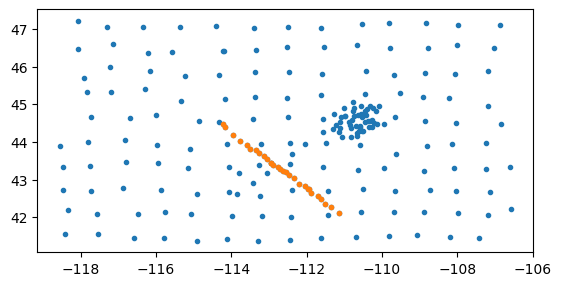

In [4]:
plt.plot(mc.dataframe['longitude'].values, mc.dataframe['latitude'].values, '.')
plt.plot(lon, lat, '.')
plt.gca().set_aspect(1)

## Step 2: Visulize transfer function at each station

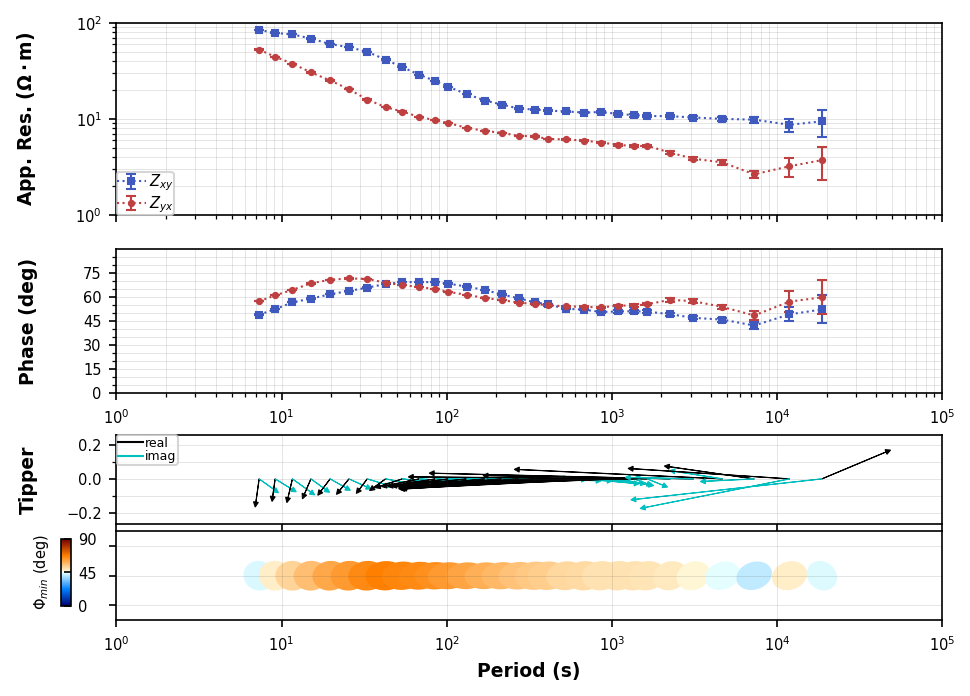

interactive(children=(Select(description='name', options=('SR205', 'SR209', 'SR212', 'SR216', 'SR220', 'SR222'…

In [5]:
from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name, component):
    tf = mc.get_tf(name)
    tf.plot_mt_response()
Q = interact(
    foo, 
    name=widgets.Select(options=station_ids),
    component=widgets.RadioButtons(options=['xy', 'yx', 'det'], value='xy')
)

## Step 3: Design a 1D vertical mesh

In [6]:
from geoana.em.fdem import skin_depth
tf = mc.get_tf(station_ids[0])
f_min = tf.frequency.min()
f_max = tf.frequency.max()
z_max = skin_depth(f_min, 1e-2) * 1
print (z_max/1e3)
z_min = skin_depth(f_max, 1e-2) / 5
print (z_min/1e3)

24:10:14T19:50:02 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR205. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.
688.6936173947421
2.7223014526313616


In [7]:
n_layer = 21
z_factor = 1.2
layer_thicknesses_inv = z_min*z_factor**np.arange(n_layer-1)[::-1]
print (z_max/1e3, np.sum(layer_thicknesses_inv)/1e3)

688.6936173947421 508.22101256083084


## Step 4: Run separate 1D inversions

In [19]:
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        # nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref, mapping=maps.IdentityMap(mesh_inv))

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    if use_irls:
        reg.norms = np.c_[p_s, p_z]
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, inv_prob.phi_d

In [20]:
resistivity_models = []
phid_s = []
# Relative error for apparent resistivity
relative_error_rho = 0.05
# Floor for phase
floor_phase = 2.
rho_0  = 100.

rho_ref = 100.
for i_station in range(len(station_ids)):
    tf = mc.get_tf(station_ids[i_station])
    # dobs = np.c_[tf.Z.res_det, tf.Z.phase_det].flatten()
    # dobs_error = np.c_[tf.Z.res_error_det, tf.Z.phase_error_det].flatten()    
    dobs = np.c_[tf.Z.phase_det].flatten()
    dobs_error = np.c_[tf.Z.phase_error_det].flatten()    

    frequencies = tf.frequency
    # rho_app = dobs.reshape((len(frequencies), 2))[:,0]
    # phase = dobs.reshape((len(frequencies), 2))[:,1]
    # standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
    standard_deviation = np.ones(len(phase))*floor_phase
    recovered_model, phi_d = run_fixed_layer_inversion(
        dobs,
        standard_deviation,
        rho_0,
        rho_ref,
        maxIter=5,
        maxIterCG=30,
        alpha_s=1e-5,
        alpha_z=1,
        beta0_ratio=1,
        coolingFactor=2,
        coolingRate=1,
        chi_factor=1
    )
    phid_s.append(phi_d)
    resistivity_models.append(1./np.exp(recovered_model))

24:10:14T19:54:25 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR205. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.

Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.71e+02  1.69e+03  0.00e+00  1.69e+03    9.06e+02      0              
   1  8.54e+01  3.06e+02  4.63e-01  3.45e+02    1.89e+02      0              
   2  4.27e+01  1.28e+02  1.07e+00  1.74e+02    1.19e+02      0       

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.81e+02  6.39e+03  0.00e+00  6.39e+03    1.05e+03      0              
   1  9.05e+01  3.86e+03  2.43e+00  4.08e+03    2.44e+02      0              
   2  4.52e+01  3.57e+03  3.05e+00  3.71e+03    1.10e+02      1              
   3  2.26e+01  3.47e+03  4.05e+00  3.56e+03    9.01e+01      1              
   4  1.13e+01  3.25e+03  1.07e+01  3.37e+03    1.04e+02      0   Skip BFGS  
   5  5.65e+00  3.15e+03  1.84e+01  3.26e+03    2.92e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.68e+02  1.76e+03  0.00e+00  1.76e+03    7.91e+02      0              
   1  8.40e+01  6.73e+02  7.13e-01  7.33e+02    3.06e+02      0              
   2  4.20e+01  4.02e+02  1.44e+00  4.62e+02    2.17e+02      0              
   3  2.10e+01  3.17e+02  1.79e+00  3.55e+02    8.51e+01      1   Skip BFGS  
   4  1.05e+01  2.65e+02  2.80e+00  2.94e+02    1.07e+02      1              
   5  5.25e+00  2.34e+02  3.83e+00  2.55e+02    2.53e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.68e+02  1.11e+03  0.00e+00  1.11e+03    5.44e+02      0              
   1  8.42e+01  1.82e+02  7.39e-01  2.44e+02    1.65e+02      0              
   2  4.21e+01  4.58e+01  1.02e+00  8.87e+01    1.18e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.1070e+02
1 : |xc-x_last| = 1.0644e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.1756e+02 <=

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.52e+02  5.08e+04  0.00e+00  5.08e+04    4.38e+03      0              
   1  7.62e+01  4.47e+04  6.39e+00  4.52e+04    3.77e+03      1              
   2  3.81e+01  3.83e+04  5.03e+00  3.85e+04    3.86e+03      1              
   3  1.90e+01  3.51e+04  2.22e+00  3.51e+04    3.87e+03      1              
   4  9.52e+00  3.49e+04  2.50e+00  3.50e+04    3.15e+03      2              
   5  4.76e+00  3.47e+04  4.23e+00  3.47e+04    2.03e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


   0  1.85e+02  1.25e+04  0.00e+00  1.25e+04    9.64e+02      0              
   1  9.23e+01  1.08e+04  1.91e+00  1.10e+04    1.64e+03      1              
   2  4.61e+01  9.42e+03  3.57e+00  9.59e+03    1.11e+03      1              
   3  2.31e+01  8.39e+03  7.52e+00  8.56e+03    1.22e+03      0              
   4  1.15e+01  8.21e+03  8.07e+00  8.30e+03    1.32e+03      1              
   5  5.77e+00  7.91e+03  9.16e+00  7.96e+03    7.00e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.4110e+02 <= tolF*(1+|f0|) = 1.2512e+03
0 : |xc-x_last| = 2.3562e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 6.9979e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.9979e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------
24:10:14T19:54:57 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.85e+02  4.31e+03  0.00e+00  4.31e+03    7.09e+02      0              
   1  9.26e+01  2.72e+03  2.29e+00  2.93e+03    2.94e+02      0              
   2  4.63e+01  2.39e+03  4.02e+00  2.57e+03    1.26e+02      0   Skip BFGS  
   3  2.32e+01  2.29e+03  5.30e+00  2.41e+03    1.59e+02      1              
   4  1.16e+01  2.24e+03  6.68e+00  2.32e+03    2.16e+02      2              
   5  5.79e+00  2.08e+03  1.31e+01  2.15e+03    2.97e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


   0  9.97e+01  6.73e+03  0.00e+00  6.73e+03    1.11e+03      0              
   1  4.99e+01  5.36e+03  7.54e+00  5.73e+03    1.11e+03      0              
   2  2.49e+01  3.55e+03  2.77e+00  3.62e+03    5.14e+02      0              
   3  1.25e+01  3.12e+03  4.20e+00  3.17e+03    2.87e+02      2              
   4  6.23e+00  3.09e+03  5.16e+00  3.13e+03    5.31e+02      3              
   5  3.12e+00  3.06e+03  5.81e+00  3.08e+03    6.01e+02      4   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 4.7078e+01 <= tolF*(1+|f0|) = 6.7288e+02
1 : |xc-x_last| = 8.8455e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 6.0074e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.0074e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------
24:10:14T19:55:11 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.69e+02  3.12e+03  0.00e+00  3.12e+03    4.46e+02      0              
   1  8.45e+01  2.50e+03  1.46e+00  2.63e+03    1.36e+02      0              
   2  4.22e+01  2.29e+03  3.16e+00  2.42e+03    9.98e+01      0   Skip BFGS  
   3  2.11e+01  2.07e+03  7.83e+00  2.24e+03    9.86e+01      0   Skip BFGS  
   4  1.06e+01  1.98e+03  9.89e+00  2.08e+03    5.95e+01      0              
   5  5.28e+00  1.92e+03  1.31e+01  1.99e+03    6.73e+

## Step 5: Plot recovered 1D resistivity models

In [21]:
RHO = np.vstack(resistivity_models)

In [22]:
top = np.cumsum(np.r_[0, layer_thicknesses_inv[::-1]])
bottom = np.cumsum(np.r_[layer_thicknesses_inv[::-1], layer_thicknesses_inv[0]])
depth = np.r_[top[0], bottom]

In [23]:
import matplotlib
matplotlib.rcParams['font.size'] = 12

In [24]:
dx = 0.02

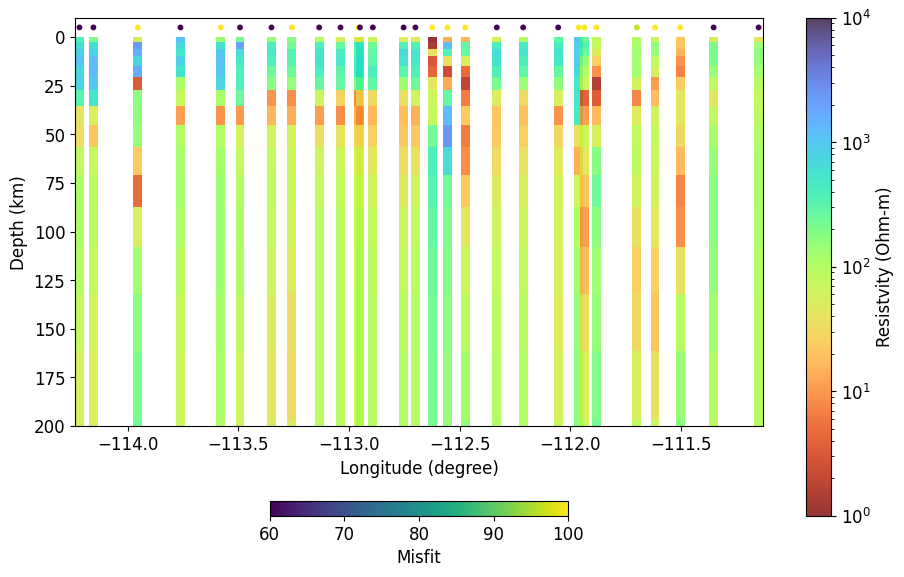

In [25]:
fig = plt.figure(figsize=(10, 6))
for ii in range(len(lon)):
    x_tmp = [lon[ii]-dx, lon[ii]+dx]
    out = plt.pcolormesh(x_tmp, depth/1e3, RHO[ii,::-1].reshape([-1,1]), norm=LogNorm(vmin=1e0, vmax=10000), cmap='turbo_r', alpha=0.8)
out_misfit = plt.scatter(lon, np.ones(len(lon)) * -0.5e1, c=phid_s, s=10, vmin=60, vmax=100)

plt.ylim(200, -1e1)
cb = plt.colorbar(out)
cb.set_label("Resistvity (Ohm-m)")
plt.xlabel("Longitude (degree)")
plt.ylabel("Depth (km)")
cb_mis = plt.colorbar(out_misfit, orientation='horizontal', fraction=0.03)
cb_mis.set_label("Misfit")


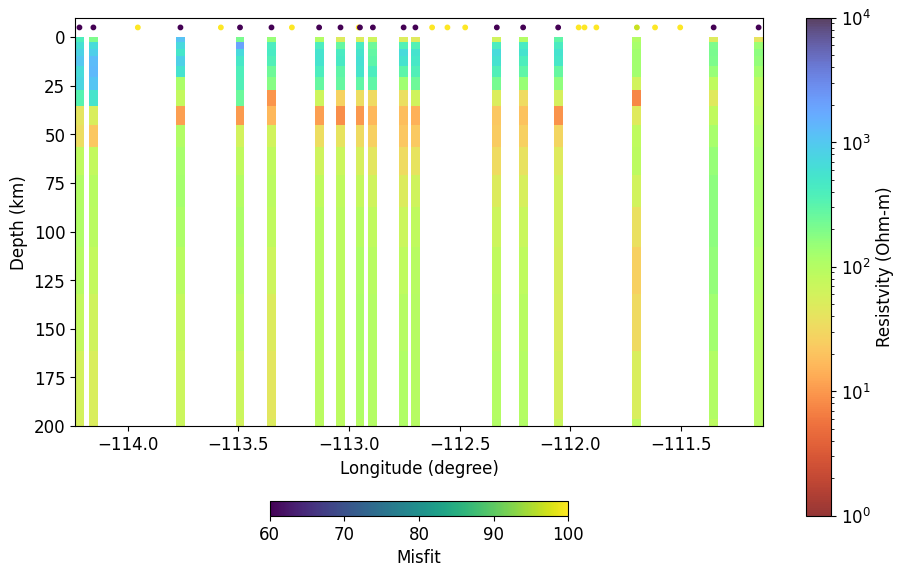

In [26]:
fig = plt.figure(figsize=(10, 6))
inds_bad = []
for ii in range(len(lon)):
    if phid_s[ii]<100:
        x_tmp = [lon[ii]-dx, lon[ii]+dx]
        out = plt.pcolormesh(x_tmp, depth/1e3, RHO[ii,::-1].reshape([-1,1]), norm=LogNorm(vmin=1e0, vmax=10000), cmap='turbo_r', alpha=0.8)
    else:
        inds_bad.append(ii)
out_misfit = plt.scatter(lon, np.ones(len(lon)) * -0.5e1, c=phid_s, s=10, vmin=60, vmax=100)

plt.ylim(200, -1e1)
cb = plt.colorbar(out)
cb.set_label("Resistvity (Ohm-m)")
plt.xlabel("Longitude (degree)")
plt.ylabel("Depth (km)")
cb_mis = plt.colorbar(out_misfit, orientation='horizontal', fraction=0.03)
cb_mis.set_label("Misfit")


In [ ]:
# Plot station with a high misfit
# ii = 0
# tf = mc.get_tf(station_ids[inds_bad[ii]])
# tf.plot_mt_response()
# print (phid_s[inds_bad[ii]])